# Training cell predictor

In this notebook, we train a model to predict a cell's next state based on its current state and that of its neighbours.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
class GameOfLifeDataset(torch.utils.data.Dataset):
    _size = 512

    def __init__(self):
        pass

    def __len__(self):
        return self._size

    def __getitem__(self, idx):
        # 12 -> "0b1100" -> "1100" -> "000001100"
        idx_bin = bin(idx)[2:].rjust(9, "0")
        X = torch.tensor([float(ch) for ch in idx_bin], dtype=torch.float32).reshape(1, 3, 3) # (channels, width, height)
        alive = X[0, 1, 1] > 0.5
        alive_neighbours = torch.sum(X) - X[0, 1, 1]
        next_alive = (alive and alive_neighbours > 1.5 and alive_neighbours < 3.5) or (not alive and alive_neighbours > 2.5 and alive_neighbours < 3.5)
        y = torch.tensor([float(next_alive)], dtype=torch.float32).reshape(1, 1) # (width, height)
        return X, y

In [3]:
dataset = GameOfLifeDataset()
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
class CellPredictorNeuralNetwork(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of shape (batch_size, channels, width+2, height+2), where channels=1. width and height are the dimensions of the entire game grid.
           We add one cell of padding on each side to ensure that predictions can be made for the boundary cells.
    
    Returns: Tensor of shape (batch_size, width, height), the logits of the predicted states.
    """

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 1)
        self.conv2 = nn.Conv2d(10, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        logits = self.conv2(x)
        logits = torch.squeeze(logits, 1) # Remove channels dimension
        return logits

In [6]:
model = CellPredictorNeuralNetwork().to(device)
print(model)

CellPredictorNeuralNetwork(
  (conv0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [7]:
X, y = next(iter(dataloader))
logits = model(X)[0]
pred_probab = F.sigmoid(logits)
y_pred = int(pred_probab > 0.5)
print(f"Predicted state: {y_pred}")

Predicted state: 1


In [8]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: CellPredictorNeuralNetwork(
  (conv0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1))
)


Layer: conv0.weight | Size: torch.Size([10, 1, 3, 3]) | Values : tensor([[[[ 0.3041,  0.1381, -0.2099],
          [ 0.0450, -0.0938,  0.0822],
          [-0.2344,  0.1384, -0.3250]]],


        [[[-0.1037, -0.1557,  0.0932],
          [ 0.0853, -0.2634, -0.2005],
          [-0.2478,  0.3111, -0.0484]]]], grad_fn=<SliceBackward0>) 

Layer: conv0.bias | Size: torch.Size([10]) | Values : tensor([-0.3141,  0.1901], grad_fn=<SliceBackward0>) 

Layer: conv1.weight | Size: torch.Size([10, 10, 1, 1]) | Values : tensor([[[[ 0.2196]],

         [[-0.3040]],

         [[-0.3161]],

         [[ 0.1085]],

         [[ 0.2893]],

         [[-0.0075]],

         [[ 0.0060]],

         [[-0.2531]],

         [[ 0.1480]],

         [[-0.3078]]],


        [[[-0.0936]],

      

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            prob = F.sigmoid(pred)
            correct += ((prob > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {
        "loss": test_loss,
        "acc": correct
    }

In [10]:
learning_rate = 1e-1
batch_size = 4
epochs = 20

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
acc_history = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
    epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
    loss_history.append(epoch_loss)
    # No need to plot test loss separately as in our case it's the same as training loss
    test_metrics = test_loop(dataloader, model, loss_fn)
    acc_history.append(test_metrics["acc"])

print("Done!")

Epoch 1
-------------------------------
loss: 0.699771  [    4/  512]
loss: 0.723301  [   84/  512]
loss: 0.739876  [  164/  512]
loss: 0.567967  [  244/  512]
loss: 0.728709  [  324/  512]
loss: 0.812786  [  404/  512]
loss: 0.199731  [  484/  512]
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.565766 

Epoch 2
-------------------------------
loss: 0.538753  [    4/  512]
loss: 0.547634  [   84/  512]
loss: 0.557980  [  164/  512]
loss: 0.539078  [  244/  512]
loss: 0.190408  [  324/  512]
loss: 0.520855  [  404/  512]
loss: 0.508928  [  484/  512]
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.484036 

Epoch 3
-------------------------------
loss: 0.318568  [    4/  512]
loss: 0.494727  [   84/  512]
loss: 0.499237  [  164/  512]
loss: 0.248158  [  244/  512]
loss: 0.436286  [  324/  512]
loss: 0.067496  [  404/  512]
loss: 0.868544  [  484/  512]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.374427 

Epoch 4
-------------------------------
loss: 0.421761  [    4/  512]
loss: 0.904338  [   84/ 

[]

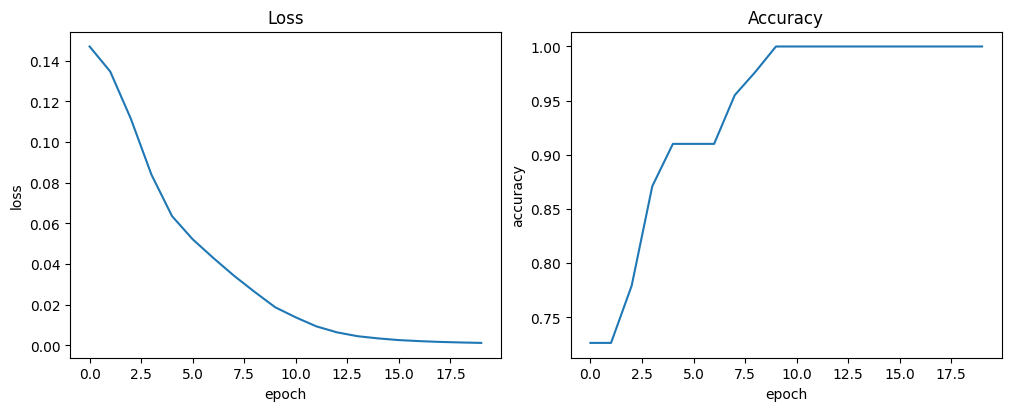

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
axs = axs.flatten()
ax_loss, ax_acc = axs

ax_loss.plot(loss_history)
ax_loss.set_title("Loss")
ax_loss.set_xlabel("epoch")
ax_loss.set_ylabel("loss")

ax_acc.plot(acc_history)
ax_acc.set_title("Accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

plt.plot()

In [12]:
torch.save(model.state_dict(), "model_weights.pth")